In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import faiss
from sklearn.manifold import TSNE
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Paths
root = Path(r"C:/Users/dilku/deepfashion-recsys")
index_path = root / "data" / "deepfashion_index.csv"
export_dir = root / "export"
export_dir.mkdir(parents=True, exist_ok=True)

# Default file names (primary expected)
baseline_gallery_path = export_dir / "gallery_embs.npy"
baseline_query_path   = export_dir / "query_embs.npy"

# fallback: baseline subset 
subset_gallery_path = export_dir / "gallery_embs_baseline_subset.npy"
subset_query_path   = export_dir / "query_embs_baseline_subset.npy"
subset_meta_path    = export_dir / "baseline_subset_index.csv"

# fine-tuned 
ft_gallery_path = export_dir / "gallery_embs_finetuned.npy"
ft_query_path   = export_dir / "query_embs_finetuned.npy"

print("Paths set")
print("Index:", index_path)
print("Export dir:", export_dir)


Paths set
Index: C:\Users\dilku\deepfashion-recsys\data\deepfashion_index.csv
Export dir: C:\Users\dilku\deepfashion-recsys\export


In [7]:
# Checking index
if not index_path.exists():
    raise FileNotFoundError(f"Index not found: {index_path}")

df = pd.read_csv(index_path)
print("Loaded deepfashion_index.csv  (rows: {})".format(len(df)))

def load_emb(path):
    if not path.exists():
        raise FileNotFoundError(f"Embeddings missing: {path}")
    arr = np.load(path)
    return arr

# Try to load the full baseline; if missing, fall back to baseline_subset
use_subset = False
if baseline_gallery_path.exists() and baseline_query_path.exists():
    print("Found full baseline embeddings.")
    baseline_gallery = load_emb(baseline_gallery_path)
    baseline_query   = load_emb(baseline_query_path)
else:
    # try fallback subset
    if subset_gallery_path.exists() and subset_query_path.exists() and subset_meta_path.exists():
        print("Full baseline not found — using baseline_subset artifacts instead.")
        baseline_gallery = load_emb(subset_gallery_path)
        baseline_query   = load_emb(subset_query_path)
        subset_meta = pd.read_csv(subset_meta_path)
        use_subset = True
    else:
        missing = []
        for p in [baseline_gallery_path, baseline_query_path, subset_gallery_path, subset_query_path, subset_meta_path]:
            if not p.exists():
                missing.append(str(p))
        raise FileNotFoundError("Neither full baseline nor subset baseline artifacts found. Missing:\n" + "\n".join(missing))

# Load fine-tuned embeddings
if not ft_gallery_path.exists() or not ft_query_path.exists():
    raise FileNotFoundError(f"Fine-tuned embeddings missing. Expected:\n - {ft_gallery_path}\n - {ft_query_path}")

ft_gallery = load_emb(ft_gallery_path)
ft_query   = load_emb(ft_query_path)

print("Baseline gallery shape:", baseline_gallery.shape)
print("Fine-tuned gallery shape:", ft_gallery.shape)

# Build gallery / query metadata frames from index
gallery_df = df[df['split'].str.contains('gallery', case=False)].reset_index(drop=True)
query_df = df[df['split'].str.contains('query', case=False)].reset_index(drop=True)

# If using subset, gallery/query metadata will be taken from subset_meta later
if not use_subset:
    assert len(gallery_df) == baseline_gallery.shape[0], "Mismatch: gallery metadata vs baseline embeddings"
    assert len(query_df) == baseline_query.shape[0], "Mismatch: query metadata vs baseline embeddings"
else:
    print("Using baseline_subset — will align fine-tuned embeddings with the subset when computing comparisons.")


Loaded deepfashion_index.csv  (rows: 52712)
Full baseline not found — using baseline_subset artifacts instead.
Baseline gallery shape: (500, 2048)
Fine-tuned gallery shape: (12612, 512)
Using baseline_subset — will align fine-tuned embeddings with the subset when computing comparisons.


In [9]:
def build_faiss_index(vecs, metric='cosine'):
    xb = vecs.astype('float32')
    if metric == 'cosine':
        faiss.normalize_L2(xb)
        index = faiss.IndexFlatIP(xb.shape[1])
    else:
        index = faiss.IndexFlatL2(xb.shape[1])
    index.add(xb)
    return index

def recall_at_k(index, query_embs, gallery_labels, query_labels, Ks=[1,5,10,20]):
    q = query_embs.astype('float32')
    faiss.normalize_L2(q)
    D, I = index.search(q, max(Ks))
    recalls = {}
    for k in Ks:
        matches = (gallery_labels[I[:, :k]] == query_labels[:, None])
        recalls[k] = matches.any(axis=1).mean() * 100
    return recalls

Ks = [1,5,10,20]

# If using the subset baseline, we must align the fine-tuned embeddings to the same subset images
if use_subset:
    # subset_meta contains image_path and role columns
    # Build mapping from full gallery/query image_path -> index in ft arrays
    full_gallery_df = gallery_df  # from index
    full_query_df = query_df

    gallery_path_to_idx = {p: i for i, p in enumerate(full_gallery_df['image_path'].tolist())}
    query_path_to_idx   = {p: i for i, p in enumerate(full_query_df['image_path'].tolist())}

    # select ft embeddings that correspond to subset rows
    def pick_ft_embeddings(sub_meta, role, path_to_idx, ft_embs):
        rows = sub_meta[sub_meta['role'] == role].reset_index(drop=True)
        picks = []
        valid_rows = []
        missing = []
        for _, r in rows.iterrows():
            p = r['image_path']
            if p in path_to_idx:
                idx = path_to_idx[p]
                picks.append(ft_embs[idx])
                valid_rows.append(r)
            else:
                missing.append(p)
        if len(missing) > 0:
            print(f"{len(missing)} {role} images from subset not found in full {role} set; they will be excluded.")
        if len(picks) == 0:
            raise RuntimeError(f"No matching {role} images found in fine-tuned embeddings.")
        return np.vstack(picks), pd.DataFrame(valid_rows).reset_index(drop=True)

    ft_gallery_subset, gallery_subset_meta = pick_ft_embeddings(subset_meta, 'gallery', gallery_path_to_idx, ft_gallery)
    ft_query_subset,   query_subset_meta   = pick_ft_embeddings(subset_meta, 'query',   query_path_to_idx, ft_query)

    # Use baseline arrays and aligned ft arrays for the subset evaluation
    print("Shapes (baseline gallery/query) :", baseline_gallery.shape, baseline_query.shape)
    print("Shapes (ft gallery/query aligned) :", ft_gallery_subset.shape, ft_query_subset.shape)

    baseline_idx = build_faiss_index(baseline_gallery, metric='cosine')
    ft_idx       = build_faiss_index(ft_gallery_subset, metric='cosine')

    gallery_labels = gallery_subset_meta['item_id'].to_numpy()
    query_labels   = query_subset_meta['item_id'].to_numpy()

    baseline_recalls = recall_at_k(baseline_idx, baseline_query, gallery_labels, query_labels, Ks)
    ft_recalls       = recall_at_k(ft_idx,       ft_query_subset, gallery_labels, query_labels, Ks)

else:
    # Full evaluation
    baseline_idx = build_faiss_index(baseline_gallery, metric='cosine')
    ft_idx       = build_faiss_index(ft_gallery, metric='cosine')

    gallery_labels = gallery_df['item_id'].to_numpy()
    query_labels   = query_df['item_id'].to_numpy()

    baseline_recalls = recall_at_k(baseline_idx, baseline_query, gallery_labels, query_labels, Ks)
    ft_recalls       = recall_at_k(ft_idx,       ft_query, gallery_labels, query_labels, Ks)

print('\nBaseline Recall@K:', baseline_recalls)
print('Fine-tuned Recall@K:', ft_recalls)

# Save CSV
comp = pd.DataFrame({
    'K': Ks,
    'baseline': [baseline_recalls[k] for k in Ks],
    'fine_tuned': [ft_recalls[k] for k in Ks]
})
comp.to_csv(export_dir / 'recall_comparison.csv', index=False)
print('Saved recall_comparison.csv at', export_dir / 'recall_comparison.csv')


Shapes (baseline gallery/query) : (500, 2048) (500, 2048)
Shapes (ft gallery/query aligned) : (500, 512) (500, 512)

Baseline Recall@K: {1: np.float64(4.0), 5: np.float64(8.200000000000001), 10: np.float64(9.8), 20: np.float64(11.4)}
Fine-tuned Recall@K: {1: np.float64(5.6000000000000005), 5: np.float64(9.0), 10: np.float64(11.600000000000001), 20: np.float64(13.200000000000001)}
Saved recall_comparison.csv at C:\Users\dilku\deepfashion-recsys\export\recall_comparison.csv


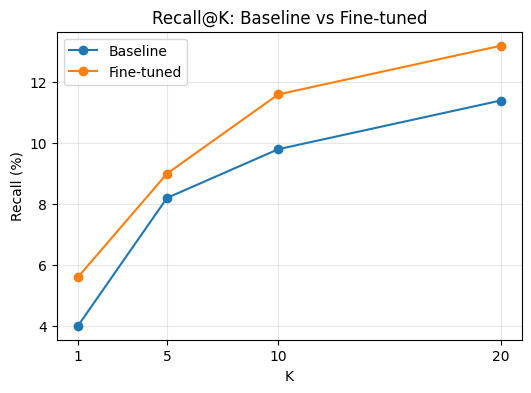

Saved plot to: C:\Users\dilku\deepfashion-recsys\export\recall_at_k_comparison.png


In [10]:
plt.figure(figsize=(6,4))
plt.plot(comp['K'], comp['baseline'], marker='o', label='Baseline')
plt.plot(comp['K'], comp['fine_tuned'], marker='o', label='Fine-tuned')
plt.xticks(comp['K'])
plt.xlabel('K')
plt.ylabel('Recall (%)')
plt.title('Recall@K: Baseline vs Fine-tuned')
plt.legend()
plt.grid(alpha=0.3)
out_png = export_dir / 'recall_at_k_comparison.png'
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()
print("Saved plot to:", out_png)


Showing qualitative results for queries: [5, 50, 200]

--- Query 5  (Baseline results)


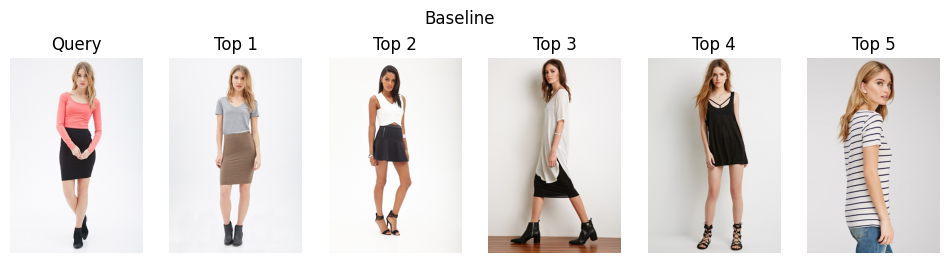


--- Query 5  (Fine-tuned results)


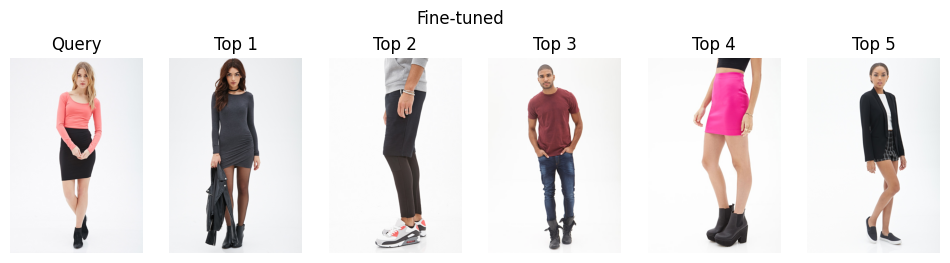


--- Query 50  (Baseline results)


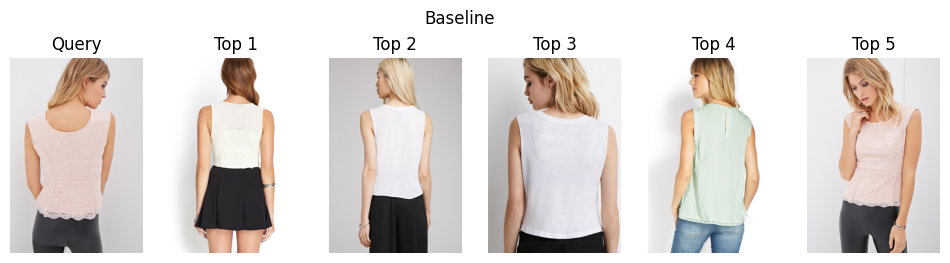


--- Query 50  (Fine-tuned results)


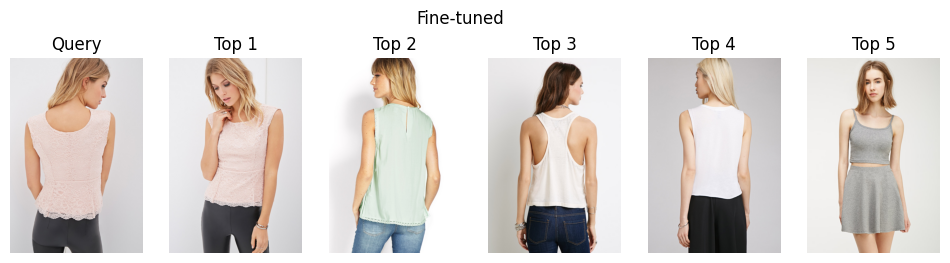


--- Query 200  (Baseline results)


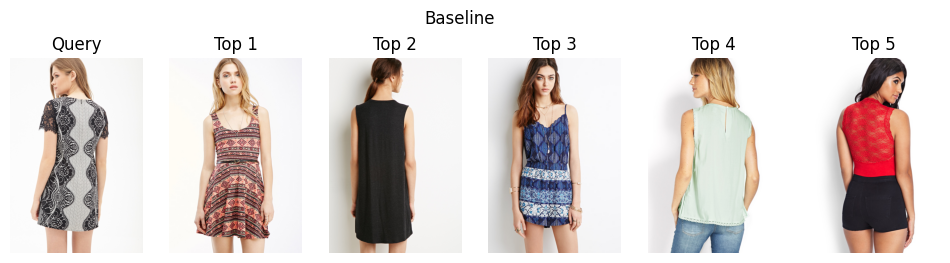


--- Query 200  (Fine-tuned results)


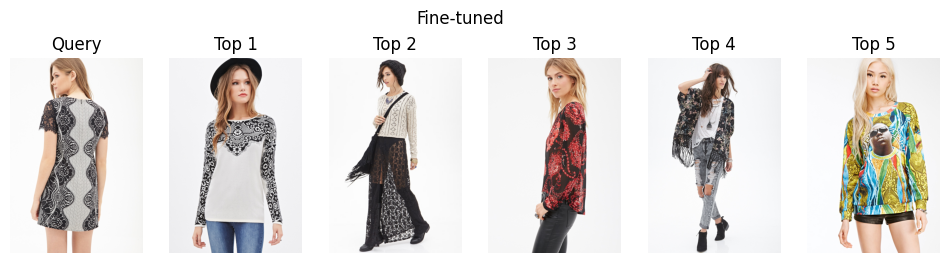

Saved example visuals to: C:\Users\dilku\deepfashion-recsys\export\example_query_visuals.png


<Figure size 640x480 with 0 Axes>

In [11]:
def show_topk_for_query(q_idx, index, query_paths, query_embs, gallery_meta, gallery_embs, title_prefix=''):
    qpath = query_paths[q_idx]
    qimg = Image.open(qpath).convert('RGB')
    qemb = query_embs[q_idx:q_idx+1].astype('float32')
    faiss.normalize_L2(qemb)
    D, I = index.search(qemb, 5)

    plt.figure(figsize=(12,3))
    plt.subplot(1,6,1)
    plt.imshow(qimg)
    plt.title('Query')
    plt.axis('off')

    for i, gi in enumerate(I[0]):
        # gi indexes into gallery_embs / gallery_meta
        gpath = gallery_meta.iloc[gi]['image_path']
        plt.subplot(1,6,i+2)
        plt.imshow(Image.open(gpath).convert('RGB'))
        plt.title(f'Top {i+1}')
        plt.axis('off')
    plt.suptitle(title_prefix)
    plt.show()

# choose a few query indices safely 
if use_subset:
    q_paths = query_subset_meta['image_path'].tolist()
    q_embs_baseline = baseline_query
    q_embs_ft = ft_query_subset
    g_meta = gallery_subset_meta
    g_embs_baseline = baseline_gallery
else:
    q_paths = query_df['image_path'].tolist()
    q_embs_baseline = baseline_query
    q_embs_ft = ft_query
    g_meta = gallery_df
    g_embs_baseline = baseline_gallery

n_queries = len(q_paths)
sample_q = [min(n_queries-1, idx) for idx in [5, 50, 200, 500] if idx < n_queries]
if len(sample_q) == 0:
    sample_q = list(range(min(4, n_queries)))

print("Showing qualitative results for queries:", sample_q)
for q in sample_q:
    print('\n--- Query', q, ' (Baseline results)')
    show_topk_for_query(q, baseline_idx, q_paths, q_embs_baseline, g_meta, g_embs_baseline, title_prefix='Baseline')
    print('\n--- Query', q, ' (Fine-tuned results)')
    show_topk_for_query(q, ft_idx, q_paths, q_embs_ft, g_meta, g_embs_baseline, title_prefix='Fine-tuned')

# Save a combined figure 
out_vis = export_dir / 'example_query_visuals.png'
plt.savefig(out_vis, dpi=150, bbox_inches='tight')
print("Saved example visuals to:", out_vis)
